In [ ]:
!pip install tensorflow==2.0.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

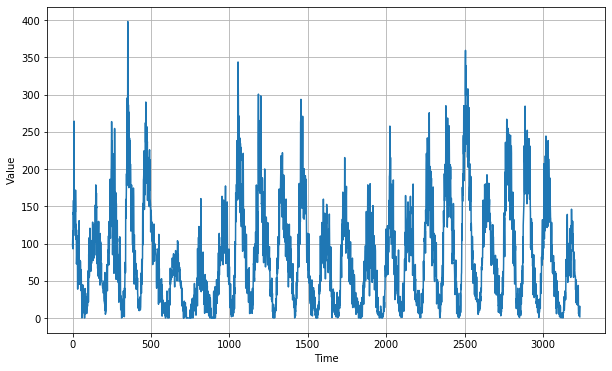

In [4]:
import csv
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
len(series)

3235

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 8s 635ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 4s 315ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 4s 311ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 4s 326ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 4s 322ms/step - loss: 68.5303 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 4s 322ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 4s 342ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 4s 344ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 4s 345ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 5s 453ms/step - loss: 34.4540 - mae: 35.6347
Epoch 83/100
12/12 [==============================] - 6s 465ms/step - loss: 43.1368 - mae: 43.2389
Epoch 84/100
12/12 [==============================] - 6s 464ms/step - loss: 39.4617 - mae: 39.5911
Epoch 85/100
12/12 [==============================] - 6s 460ms/step - loss: 49.1744 - mae: 49.5942
Epoch 86/100
12/12 [==============================] - 5s 457ms/step - loss: 56.4021 - mae: 57.0151
Epoch 87/100
12/12 [==============================] - 6s 466ms/step - loss: 53.9250 - mae: 54.6043
Epoch 88/100
12/12 [==============================] - 5s 456ms/step - loss: 53.1373 - mae: 53.6388
Epoch 89/100
12/12 [==============================] - 5s 449ms/step - loss: 48.4984 - mae: 49.3936
Epoch 90/100
12/12 [==============================] - 6s 471ms/step - loss: 55.0827 - mae: 55.6935
Epoch 91/100
12/12 [==============================] - 6s 463ms/step - loss: 57.2550 - mae: 57.7317
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

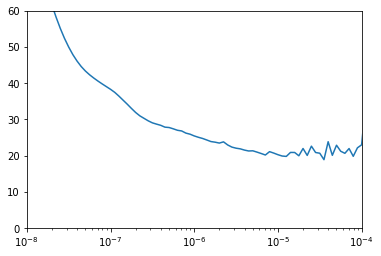

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 9s 316ms/step - loss: 37.8896 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 5s 168ms/step - loss: 24.1466 - mae: 24.6111
Epoch 3/500
30/30 [==============================] - 5s 176ms/step - loss: 22.0289 - mae: 22.5206
Epoch 4/500
30/30 [==============================] - 6s 214ms/step - loss: 19.8096 - mae: 20.3090
Epoch 5/500
30/30 [==============================] - 6s 198ms/step - loss: 19.4837 - mae: 19.9824
Epoch 6/500
30/30 [==============================] - 6s 216ms/step - loss: 19.1767 - mae: 19.6673
Epoch 7/500
30/30 [==============================] - 6s 203ms/step - loss: 18.7565 - mae: 19.2611
Epoch 8/500
30/30 [==============================] - 6s 206ms/step - loss: 18.4685 - mae: 18.9426
Epoch 9/500
30/30 [==============================] - 6s 193ms/step - loss: 18.3787 - mae: 18.8855
Epoch 10/500
30/30 [==============================] - 7s 227ms/step - loss: 18.2789 - mae: 18.7812
Epoch 11/500
30/30 

30/30 [==============================] - 5s 156ms/step - loss: 16.3144 - mae: 16.8168
Epoch 84/500
30/30 [==============================] - 5s 157ms/step - loss: 16.3179 - mae: 16.8135
Epoch 85/500
30/30 [==============================] - 5s 154ms/step - loss: 16.3138 - mae: 16.8077
Epoch 86/500
30/30 [==============================] - 5s 173ms/step - loss: 16.3586 - mae: 16.8557
Epoch 87/500
30/30 [==============================] - 4s 148ms/step - loss: 16.4483 - mae: 16.9514
Epoch 88/500
30/30 [==============================] - 4s 149ms/step - loss: 16.7809 - mae: 17.2917
Epoch 89/500
30/30 [==============================] - 4s 149ms/step - loss: 16.3469 - mae: 16.8336
Epoch 90/500
30/30 [==============================] - 4s 149ms/step - loss: 16.3475 - mae: 16.8336
Epoch 91/500
30/30 [==============================] - 5s 162ms/step - loss: 16.3659 - mae: 16.8584
Epoch 92/500
30/30 [==============================] - 5s 150ms/step - loss: 16.3230 - mae: 16.8242
Epoch 93/500
30/30 [===

30/30 [==============================] - 5s 153ms/step - loss: 15.9289 - mae: 16.4292
Epoch 165/500
30/30 [==============================] - 5s 151ms/step - loss: 15.8234 - mae: 16.3324
Epoch 166/500
30/30 [==============================] - 5s 153ms/step - loss: 16.0796 - mae: 16.5563
Epoch 167/500
30/30 [==============================] - 5s 151ms/step - loss: 15.8054 - mae: 16.2967
Epoch 168/500
30/30 [==============================] - 5s 152ms/step - loss: 15.8018 - mae: 16.3079
Epoch 169/500
30/30 [==============================] - 5s 152ms/step - loss: 15.8618 - mae: 16.3584
Epoch 170/500
30/30 [==============================] - 5s 156ms/step - loss: 15.7735 - mae: 16.2563
Epoch 171/500
30/30 [==============================] - 5s 152ms/step - loss: 15.8951 - mae: 16.3885
Epoch 172/500
30/30 [==============================] - 5s 168ms/step - loss: 15.7139 - mae: 16.2068
Epoch 173/500
30/30 [==============================] - 4s 147ms/step - loss: 15.8351 - mae: 16.3142
Epoch 174/500


30/30 [==============================] - 4s 146ms/step - loss: 15.2950 - mae: 15.7913
Epoch 246/500
30/30 [==============================] - 4s 149ms/step - loss: 15.6293 - mae: 16.0949
Epoch 247/500
30/30 [==============================] - 5s 152ms/step - loss: 15.3617 - mae: 15.8192
Epoch 248/500
30/30 [==============================] - 5s 153ms/step - loss: 15.3316 - mae: 15.8368
Epoch 249/500
30/30 [==============================] - 4s 148ms/step - loss: 15.3621 - mae: 15.8685
Epoch 250/500
30/30 [==============================] - 4s 149ms/step - loss: 15.4353 - mae: 15.9178
Epoch 251/500
30/30 [==============================] - 4s 148ms/step - loss: 15.3271 - mae: 15.7950
Epoch 252/500
30/30 [==============================] - 5s 153ms/step - loss: 15.4072 - mae: 15.8833
Epoch 253/500
30/30 [==============================] - 4s 146ms/step - loss: 15.2546 - mae: 15.7406
Epoch 254/500
30/30 [==============================] - 4s 149ms/step - loss: 15.2865 - mae: 15.7799
Epoch 255/500


30/30 [==============================] - 4s 147ms/step - loss: 14.9868 - mae: 15.4720
Epoch 328/500
30/30 [==============================] - 4s 148ms/step - loss: 14.9384 - mae: 15.4209
Epoch 329/500
30/30 [==============================] - 4s 146ms/step - loss: 14.9962 - mae: 15.4890
Epoch 330/500
30/30 [==============================] - 4s 148ms/step - loss: 14.9661 - mae: 15.4486
Epoch 331/500
30/30 [==============================] - 4s 144ms/step - loss: 14.8979 - mae: 15.3760
Epoch 332/500
30/30 [==============================] - 4s 147ms/step - loss: 14.9343 - mae: 15.4163
Epoch 333/500
30/30 [==============================] - 4s 147ms/step - loss: 14.9367 - mae: 15.4233
Epoch 334/500
30/30 [==============================] - 4s 144ms/step - loss: 14.8501 - mae: 15.3484
Epoch 335/500
30/30 [==============================] - 4s 146ms/step - loss: 14.9411 - mae: 15.4168
Epoch 336/500
30/30 [==============================] - 4s 147ms/step - loss: 14.9845 - mae: 15.4697
Epoch 337/500


30/30 [==============================] - 5s 155ms/step - loss: 14.5349 - mae: 15.0265
Epoch 410/500
30/30 [==============================] - 4s 144ms/step - loss: 14.5238 - mae: 15.0113
Epoch 411/500
30/30 [==============================] - 4s 149ms/step - loss: 14.5539 - mae: 15.0423
Epoch 412/500
30/30 [==============================] - 4s 146ms/step - loss: 14.6784 - mae: 15.1679
Epoch 413/500
30/30 [==============================] - 5s 154ms/step - loss: 14.5659 - mae: 15.0536
Epoch 414/500
30/30 [==============================] - 5s 158ms/step - loss: 14.4984 - mae: 14.9857
Epoch 415/500
30/30 [==============================] - 5s 163ms/step - loss: 14.5999 - mae: 15.0767
Epoch 416/500
30/30 [==============================] - 4s 150ms/step - loss: 14.7234 - mae: 15.2166
Epoch 417/500
30/30 [==============================] - 5s 157ms/step - loss: 14.5745 - mae: 15.0496
Epoch 418/500
30/30 [==============================] - 5s 153ms/step - loss: 14.5316 - mae: 15.0214
Epoch 419/500


30/30 [==============================] - 4s 144ms/step - loss: 14.4104 - mae: 14.8947
Epoch 491/500
30/30 [==============================] - 4s 147ms/step - loss: 14.1354 - mae: 14.6296
Epoch 492/500
30/30 [==============================] - 4s 144ms/step - loss: 14.1653 - mae: 14.6451
Epoch 493/500
30/30 [==============================] - 4s 147ms/step - loss: 14.1726 - mae: 14.6654
Epoch 494/500
30/30 [==============================] - 5s 151ms/step - loss: 14.2124 - mae: 14.6888
Epoch 495/500
30/30 [==============================] - 5s 164ms/step - loss: 14.1749 - mae: 14.6549
Epoch 496/500
30/30 [==============================] - 5s 158ms/step - loss: 14.1374 - mae: 14.6346
Epoch 497/500
30/30 [==============================] - 5s 165ms/step - loss: 14.1282 - mae: 14.6306
Epoch 498/500
30/30 [==============================] - 5s 153ms/step - loss: 14.1352 - mae: 14.6299
Epoch 499/500
30/30 [==============================] - 5s 161ms/step - loss: 14.4243 - mae: 14.9148
Epoch 500/500


In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)